## imports

In [423]:
import collections
import glob
import json
import os
import uuid

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.legend import Legend
import pandas as pd
from scipy import ndimage

## utilities

### I/O

In [406]:
def read_events(fname):
    success_statuses = ['KSP_CONVERGED_RTOL', 'SCIPY_SUCCESS', 'AZ_normal', 
                        'KSP_CONVERGED_ITS', 'KSP_CONVERGED_RTOL', 
                        'Pysparse_CONVERGED_RTOL', 'AMGX_SOLVE_SUCCESS']
    events = []
    state = {}
    versions = {}

    with open(fname, 'r') as f:
        begin_time = np.nan
        solve_time = np.nan
        simulation_id = np.nan
        for line in f:
            entries = line.split("|")
            # Python version uses '|', too
            entries = entries[:4] + ["|".join(entries[4:])]

            (time_stamp,
             level,
             logger,
             function,
             msg) = [s.strip() for s in entries]

            if (logger, function) == ("fipy.solvers", "<module>"):
                pass
            elif (level, logger, function) == ("DEBUG", "fipy", "<module>"):
                versions = json.loads(msg)
                # # fix name collision
                # versions["package"]["solver_suite"] = versions["package"]["solver"]
                # del versions["package"]["solver"]
            elif (level, logger, function) == ("INFO", "fipy", "<module>"):
                # obsolete log format
                versions = {"package": json.loads(msg)}
            elif (level, function) == ("DEBUG", "<module>"):
                if msg.startswith("result stored in"):
                    continue
                state = json.loads(msg)
                state["logfile"] = fname
                state["time_stamp"] = time_stamp
                state["solver_class"] = logger.split('.')[-1]
                state["solve_time"] = str(solve_time)
                if state["state"] == "START":
                    # create unique id for each simulation run
                    simulation_id = uuid.uuid4()
                    converged = False
                state["simulation_id"] = simulation_id
                state["converged"] = converged
                state.update(versions)
                events.append(state.copy())
            elif (level, function) == ("DEBUG", "_setConvergence"):
                state["state"] = "SWEEP"
                event = json.loads(msg)
                event.update(state.copy())
                event["time_stamp"] = time_stamp
                event["solver_class"] = logger.split('.')[-1]
                event["solve_time"] = str(solve_time)
                converged = event["status_name"] in success_statuses
                events.append(event)
            elif (level, function) == ("DEBUG", "_solve_"):
                if msg == "BEGIN solve":
                    begin_time = pd.to_datetime(time_stamp)
                    solve_time = np.nan
                elif msg == "END solve":
                    solve_time = pd.to_datetime(time_stamp) - begin_time
                    begin_time = np.nan

    return events

def events2df(events):
    df = pd.json_normalize(events)
    df["time_stamp"] = pd.to_datetime(df["time_stamp"])
    df["solve_time"] = pd.to_timedelta(df["solve_time"])    
    df.loc[df["preconditioner"].isna()
           | (df["preconditioner"] == "NoneType"), "preconditioner"] = "unpreconditioned"

    return df

def extract_total_times(df):
    df2 = df[df["state"].isin(["START", "END"])].copy()
    df2["time_delta"] = df2["time_stamp"].diff()
    df2["elapsed_seconds"] = df2["time_delta"] / pd.Timedelta("00:00:01")

    return df2[df2["state"] == "END"].sort_values("numberOfElements")

def extract_sweep_times(df):
    df2 = df.copy()
    df2["time_delta"] = df["time_stamp"].diff()
    df2["elapsed_seconds"] = df2["time_delta"] / pd.Timedelta("00:00:01")

    return df2[~df2["state"].isin(["START", "END"])]

### miscellaneous

In [39]:
def is_converged(paths, df):
    converged = {}
    for path in paths:
        suite, solver, preconditioner, numberOfElements = path.split('/')[-5:-1]
        if preconditioner == "NoneType":
            preconditioner = "unpreconditioned"
        status = df[(df['package.solver'] == suite)
                    & (df['solver_class'] == solver)
                    & (df['preconditioner'] == preconditioner)
                    & (df['numberOfElements'] == int(numberOfElements))
                    & (df['state'] == "SWEEP")].iloc[-1]['status_name']

        converged[path] = status in ["KSP_CONVERGED_RTOL", "SCIPY_SUCCESS"]

    return converged

### plot scaling

In [444]:
def plot_all(df, color_by_suite=True,
             by=["package.solver", "solver_class", "preconditioner"]):
    color_map = {
        'no-pysparse': 'red',
        'trilinos': 'red',
        'petsc': 'blue',
        'scipy': 'green',
        'pysparse': 'orange',
        'pyamgx': 'cyan'
    }
    
    fig, ax = plt.subplots(figsize=(8,6))
    groups = df.groupby(by + ["numberOfElements"])
    groups = groups.agg(converged=("converged", "all"),
                        count=("elapsed_seconds", "count"),
                        mean=("elapsed_seconds", "mean"),
                        std=("elapsed_seconds", "std")).reset_index()
    groups = groups.groupby(by)
    for key, group in groups:
        if color_by_suite:
            color = color_map[key[0]]
            group.mask(~group["converged"].astype(bool)).plot("numberOfElements", "mean", loglog=True,
                       ax=ax, label=key, color=color, marker=".", markersize=1.5)
            group.mask(group["converged"].astype(bool)).plot("numberOfElements", "mean", loglog=True,
                       ax=ax, label=None, color=color, marker="x", linestyle="")
        else:
            group.mask(~group["converged"].astype(bool)).plot("numberOfElements", "mean", loglog=True,
                       ax=ax, label=key, marker=".", markersize=1.5)
            color = ax.lines[-1].get_color()
            group.mask(group["converged"].astype(bool)).plot("numberOfElements", "mean", loglog=True,
                       ax=ax, label=None, color=color, marker="x", linestyle="")
            
        # plot uncertainty
        err = group["std"] / np.sqrt(group["count"])
        ax.fill_between(group["numberOfElements"],
                        group["mean"] - err,
                        group["mean"] + err,
                        color=color,
                        alpha=0.1)

    if color_by_suite:
        legend_elements = [Line2D([0], [0], color=c, label=s)
                           for s, c in color_map.items()
                           if s in df["package.solver"].unique()]
        ax.legend(handles=legend_elements, bbox_to_anchor=(1., 1.))
    else:
        # only label converged lines
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::2], labels[::2], bbox_to_anchor=(1., 1.))

    if ~df["converged"].astype(bool).all():
        legend_elements = [Line2D([0], [0], color="black", marker=".", markersize=1.5),
                           Line2D([0], [0], color="black", linewidth=0, marker="x")]
        leg = Legend(ax, handles=legend_elements, labels=["converged", "not converged"],
                     loc='upper left', frameon=False)
        ax.add_artist(leg);

    ax.set_ylabel("elapsed time / s")
    ax.set_xlabel("number of elements")

def plot_by_solver(df):
    for solver_class, group1 in df.groupby(["solver_class"]):
        plot_all(group1, by=["package.solver", "preconditioner"])
        plt.title(solver_class)
        
def plot_sweep_times(df):
    for numberOfElements, group1 in df.groupby("numberOfElements"):
        fig, ax = plt.subplots(figsize=(8,6))
        for label, group2 in group1.groupby(["package.solver", "solver_class", "preconditioner"]):
            group2 = group2.reset_index()
            group2.plot(y="elapsed_seconds", ax=ax, label=label, logy=True)
        _ = plt.xlim(xmax=9)
        plt.legend(loc="upper right", bbox_to_anchor=(1.7, 1.0))
        plt.title("size = {0}x{0}".format(int(np.sqrt(numberOfElements))))
        plt.ylabel("sweep time / s")
        plt.xlabel("sweep")        

### plot solutions

In [41]:
def sort_directories_numerically(paths):
    splitted = [s.split('/') for s in paths]
    splitted = [s[:-2] + [int(s[-2]), s[-1]] for s in splitted]
    splitted.sort()
    splitted = [s[:-2] + [str(s[-2]), s[-1]] for s in splitted]
    return ['/'.join(s) for s in splitted]

def read_tsv(tsv):
    x, y, v = np.loadtxt(tsv, skiprows=1, unpack=True)
    N = int(np.sqrt(len(x)))
    return [field.reshape((N,N)) for field in (x, y, v)] + [N]

def read_npz(npz):
    data = np.load(npz)
    return data["x"], data["y"], data["value"], data["value"].shape[0]

def tsv2npz(tsv):
    x, y, v, N = read_tsv(tsv)
    np.savez(os.path.splitext(tsv)[0], x=x, y=y, value=v)

def compare(coarse, fine):
    # "gpu/pyamgx/LinearGMRESSolver/10000/solution.tsv"
    x_coarse, y_coarse, v_coarse, N_coarse = read_tsv(coarse)
    x_fine, y_fine, v_fine, N_fine = read_tsv(fine)

    fig = plt.figure(figsize=(16,12))
    ax1 = fig.add_subplot(131)  # coarse
    ax2 = fig.add_subplot(132)  # error
    ax3 = fig.add_subplot(133)  # fine
    resampled = ndimage.zoom(v_fine, N_coarse / N_fine)
    ax1.imshow(v_coarse, vmin=v_fine.min(), vmax=v_fine.max())
    ax2.imshow(resampled-v_coarse, vmin=v_fine.min(), vmax=v_fine.max())
    ax3.imshow(resampled, vmin=v_fine.min(), vmax=v_fine.max())

    ax2.set_title("{0}x{0}: L2(error) = {1}".format(N_coarse, np.sqrt(((resampled - v_coarse)**2)).sum() / N_coarse**2))

def get_diff(path1, path2, key="value"):
    """Load and intorpolate `path2` to resolution of `path1`
    
    Parameters
    ----------
    path1, path2 : str
        Paths to `.npz` files containing x-coordinates, y-coordinates, and values
        for square arrays of values.
    key : str
        Key holding data of interest

    Returns
    -------
    diff : ndarray
        Difference between `path1` and `path2`
        (at resolution of whichever is lower).
    norm : float
        L2-norm of `diff`.
    N1, N2 : float
        Dimensions of `path1` and `path2`.
    """
    # x1, x1, v1, N1 = read_npz(path1)
    # x2, x2, v2, N2 = read_npz(path2)

    data1 = np.load(path1)
    data2 = np.load(path2)
    
    v1 = data1[key]
    v2 = data2[key]
    
    N1 = v1.shape[0]
    N2 = v2.shape[0]

    if N1 == N2:
        diff = v2 - v1
        L2norm = np.sqrt((diff**2).sum()) / N1**2
    elif N2 > N1:
        resampled = ndimage.zoom(v2, N1 / N2)
        diff = resampled-v1
        L2norm = np.sqrt((diff**2).sum()) / N1**2
    else:
        resampled = ndimage.zoom(v1, N2 / N1)
        diff = v2 - resampled
        L2norm = np.sqrt((diff**2).sum()) / N2**2
    
    return diff, L2norm, N1, N2    

In [5]:
def count_path_components(paths, skip=0):
    label_counts = []
    split_paths = [path.split('/') for path in paths]
    # walk backwards through path components and collect common entries
    for i in range(skip,len(paths[0].split('/'))):
        labels = [path[-(i+1)] for path in split_paths]
        label_counts.append(collections.Counter(labels))

    return label_counts

def squeeze_runs_of_one(label_counts):
    previous_len = -1
    squeezed_labels = []
    for level in label_counts:
        if len(level) == 1:
            # all paths have the same value at this level
            if previous_len == 1:
                # prepend the cache with the new label
                key_prev, num_prev = squeezed_labels.pop().most_common()[0]
                key_new, num_new = level.most_common()[0]
                level = [f"{key_new} - {key_prev}"] * num_prev
                level = collections.Counter(level)

        previous_len = len(level)
        squeezed_labels.append(level)

    return squeezed_labels

In [645]:
def perpendicular_xlabel(ax, level, color, label):
    ax.annotate(label, (0.5, 1), xytext=(0, 10),
                textcoords='offset points', xycoords='axes fraction',
                ha='center', va='bottom', size=8, rotation=90, color=color)

def parallel_xlabel(ax, level, color, label):
    ax.annotate(label, (0.5, 1), xytext=(0, 60 + 20 * level),
                textcoords='offset points', xycoords='axes fraction',
                ha='center', va='center', size=10, color=color)

def perpendicular_ylabel(ax, level, color, label):
    ax.annotate(label, (0, 0.5), xytext=(-10, 0),
                textcoords='offset points', xycoords='axes fraction',
                ha='right', va='center', size=8, rotation=0, color=color)

def parallel_ylabel(ax, level, color, label):
    ax.annotate(label, (0, 0.5), xytext=(-(60 + 20 * level), 0),
                textcoords='offset points', xycoords='axes fraction',
                ha='center', va='center', size=10, rotation=90, color=color)

def label_multiindex(df, axs, perpendicular_label_fn, parallel_label_fn, offset=0):
    if not isinstance(df, pd.DataFrame):
        return 0, 1
    elif isinstance(df.index, pd.MultiIndex):
        labels = df.index.levels[0]
        name = df.index.names[0]
    else:
        labels = df.index
        name = df.index.name

    count = 0
    for label in labels:
        labeldf = df.loc[label]
        level, num = label_multiindex(labeldf,
                                      axs, perpendicular_label_fn, parallel_label_fn,
                                      offset=count)

        if name == "numberOfElements":
            label = '{0}x{0}'.format(int(np.sqrt(label)))

        try:
            converged = bool(labeldf.all())
        except ValueError:
            converged = bool(labeldf.all().all())
        if converged:
            color = "black"
        else:
            color = "red"

        ax = axs[offset + count + num // 2]
        if level == 0:
            perpendicular_label_fn(ax, level, color, label)
        else:
            parallel_label_fn(ax, level, color, label)
            
        # print(level, offset + (count + num / 2), color, name, label)
        count += num
    return level + 1, count

In [627]:
def path_to_file(df, suffix):
    preconditioner = df["preconditioner"]
    if preconditioner == "unpreconditioned":
        preconditioner = "NoneType"

    return os.path.join(os.path.dirname(df["logfile"]),
                        df["package.solver"], df["solver_class"],
                        preconditioner, str(df["numberOfElements"]),
                        suffix)

def plot_error_matrix(dfA, dfB, by, datafile, key="value"):
    groupsA = dfA.groupby(by)
    groupsB = dfB.groupby(by)
    
    fig, axs = plt.subplots(nrows=len(groupsA), ncols=len(groupsB),
                            figsize=(10, 10 * len(groupsB) / len(groupsA)))
    plt.setp(axs.flat, xticks=[], yticks=[])

    converged_cmap = mpl.cm.get_cmap('viridis').copy()
    converged_cmap.set_bad(color='black')

    diverged_cmap = mpl.cm.get_cmap('inferno').copy()
    diverged_cmap.set_bad(color='black')

    for col, (keyA, groupA) in zip(axs.T, groupsA):
        for ax, (keyB, groupB) in zip(col, groupsB):
            diff, norm, N1, N2 = get_diff(path_to_file(groupA.iloc[0], suffix=datafile),
                                          path_to_file(groupB.iloc[0], suffix=datafile),
                                          key)
            
            if groupA["converged"].all() & groupB["converged"].all():
                cmap = converged_cmap
            else:
                cmap = diverged_cmap
            ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)

    convergedA = groupsA.agg({"converged": "all"})
    label_multiindex(convergedA, axs[0], perpendicular_xlabel, parallel_xlabel)
    
    convergedB = groupsB.agg({"converged": "all"})
    label_multiindex(convergedB, axs[:, 0], perpendicular_ylabel, parallel_ylabel)

In [402]:
def plot_error_matrix_OLD(patternA, patternB, df, key="value"):
    pathsA = glob.glob(patternA)
    pathsB = glob.glob(patternB)

    pathsA = sort_directories_numerically(pathsA)
    pathsB = sort_directories_numerically(pathsB)

    NA = len(pathsA)
    NB = len(pathsB)

    convergedA = is_converged(pathsA, df)
    convergedB = is_converged(pathsB, df)

    fig, axs = plt.subplots(nrows=NB, ncols=NA, figsize=(10, 10 * NB / NA))
    plt.setp(axs.flat, xticks=[], yticks=[])

    converged_cmap = mpl.cm.get_cmap('viridis').copy()
    converged_cmap.set_bad(color='black')

    diverged_cmap = mpl.cm.get_cmap('inferno').copy()
    diverged_cmap.set_bad(color='black')

    for col, pathA in zip(axs.T, pathsA[:NA]):
        for ax, pathB in zip(col, pathsB[:NB]):
            diff, norm, N1, N2 = get_diff(pathA, pathB, key)
            
            if convergedA[pathA] & convergedB[pathB]:
                cmap = converged_cmap
            else:
                cmap = diverged_cmap
            ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)

    for ax, pathA in zip(axs[0], pathsA):
        segments = pathA.split('/')
        if convergedA[pathA]:
            color = "black"
        else:
            color = "red"
        ax.set_title('{0}x{0}'.format(int(np.sqrt(float(segments[-2])))), size=8,
                     rotation=90, fontdict={'color': color})
    for ax, pathB in zip(axs[:, 0], pathsB):
        segments = pathB.split('/')
        if convergedB[pathB]:
            color = "black"
        else:
            color = "red"
        ax.set_ylabel('{0}x{0}'.format(int(np.sqrt(float(segments[-2])))), size=8,
                      ha="right", va='center', rotation=0, fontdict={'color': color})

    label_counts = squeeze_runs_of_one(count_path_components(pathsA, skip=2))
    for i, level in enumerate(label_counts):
        offset = 0
        for label, count in level.items():
            idx = offset + count // 2
            if label == "NoneType":
                label = "unpreconditioned"
            axs[0, idx].annotate(label, (0.5, 1), xytext=(0, 60 + 20 * i),
                                 textcoords='offset points', xycoords='axes fraction',
                                 ha='center', va='center', size=8)
            offset += count

    label_counts = squeeze_runs_of_one(count_path_components(pathsB, skip=2))
    for i, level in enumerate(label_counts):
        offset = 0
        for label, count in level.items():
            idx = offset + count // 2
            if label == "NoneType":
                label = "unpreconditioned"
            axs[idx, 0].annotate(label, (0.5, 1), xytext=(-(70 + 20 * i), 0),
                                 textcoords='offset points', xycoords='axes fraction',
                                 ha='center', va='center', size=8, rotation=90)
            offset += count

## diffusion

### macOS

In [370]:
events = read_events("macOS/macos.log")

macos = events2df(events)
macos_total = extract_total_times(macos)

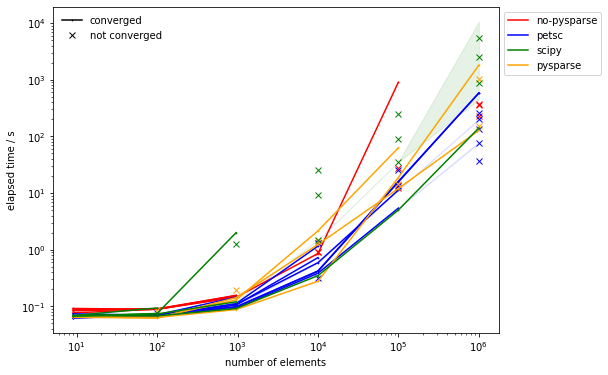

In [373]:
plot_all(macos_total)

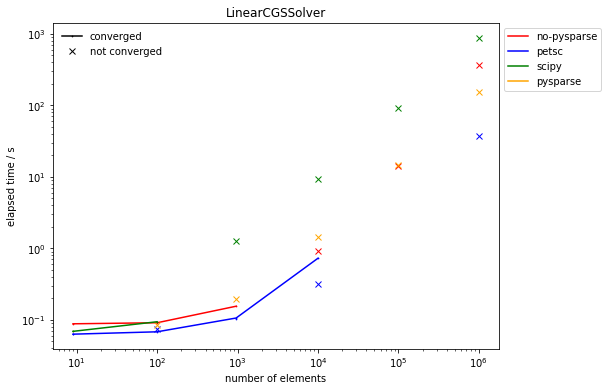

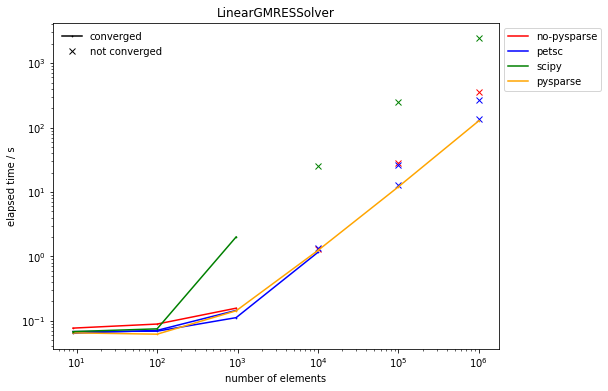

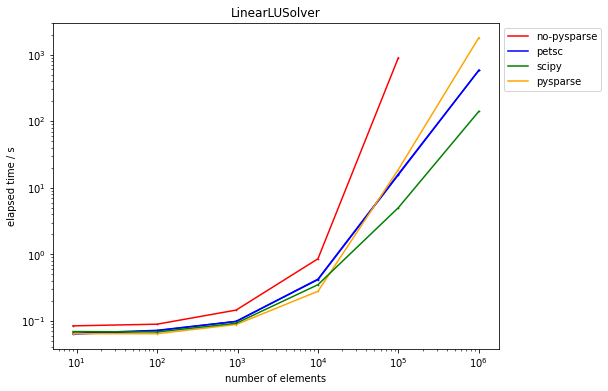

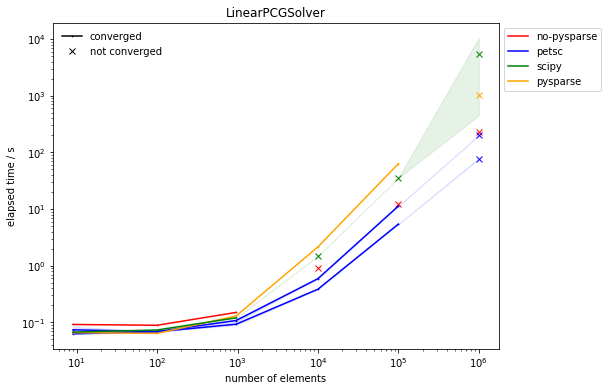

In [374]:
plot_by_solver(macos_total)

In [375]:
macos_sweep = extract_sweep_times(macos)

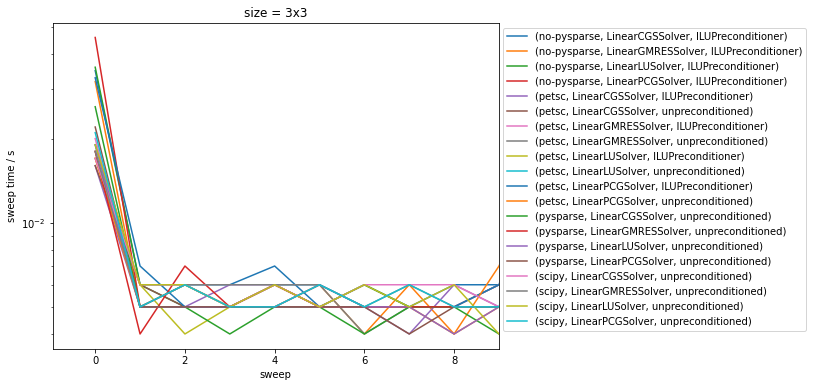

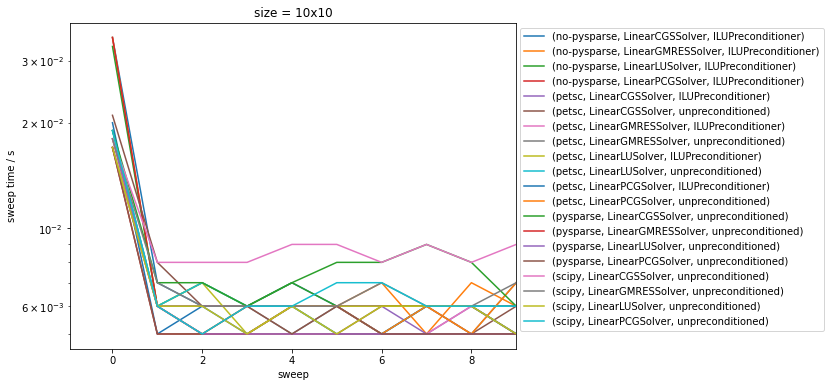

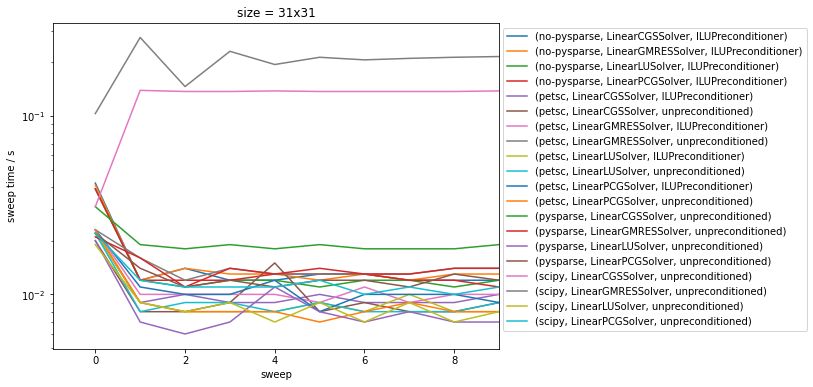

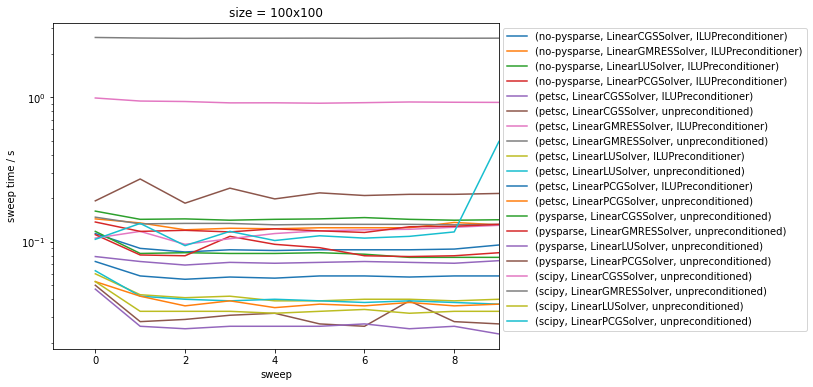

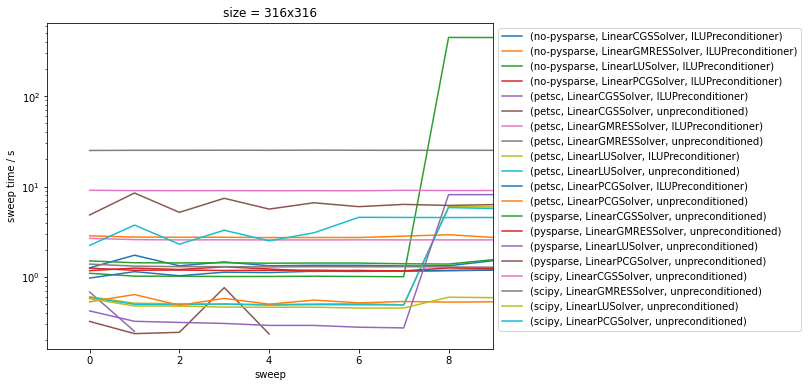

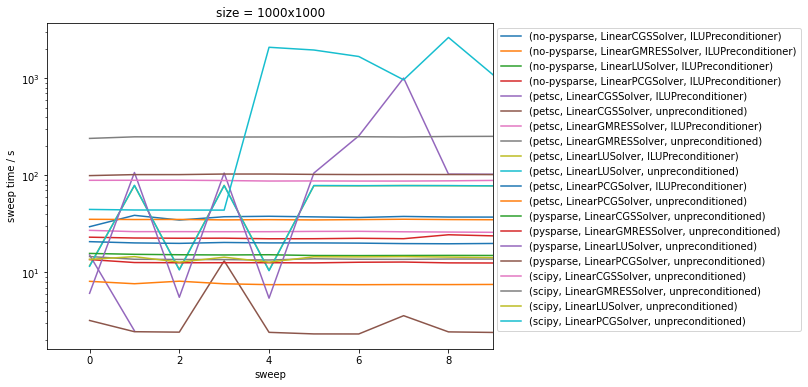

In [376]:
plot_sweep_times(macos_sweep)

### GPUs

In [377]:
gpu = events2df(read_events("gpu/gpu.log"))
gpu_total = extract_total_times(gpu)

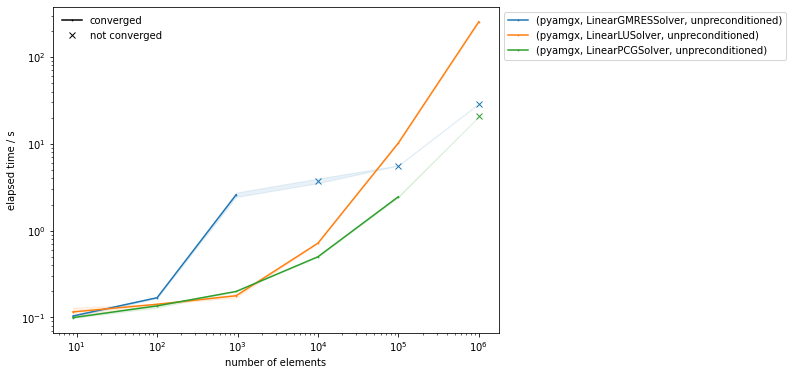

In [379]:
plot_all(gpu_total, color_by_suite=False)

In [380]:
gpu_sweep = extract_sweep_times(gpu)

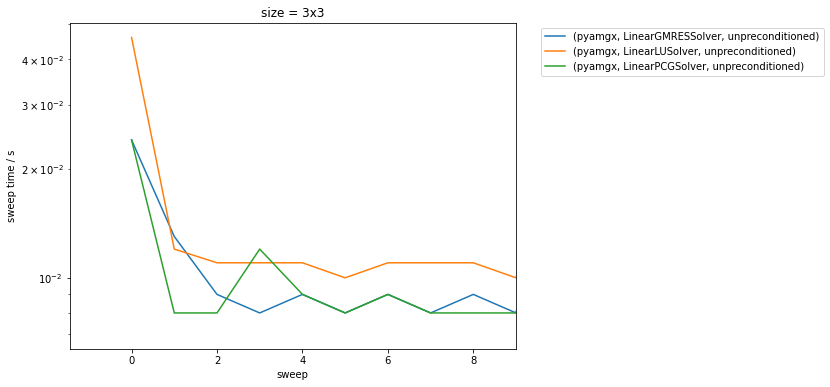

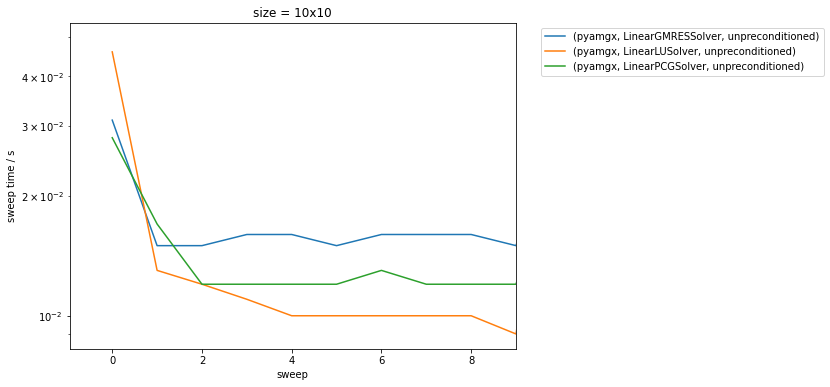

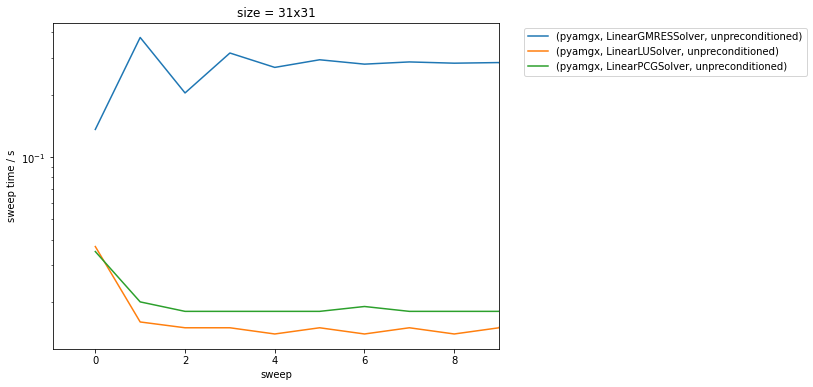

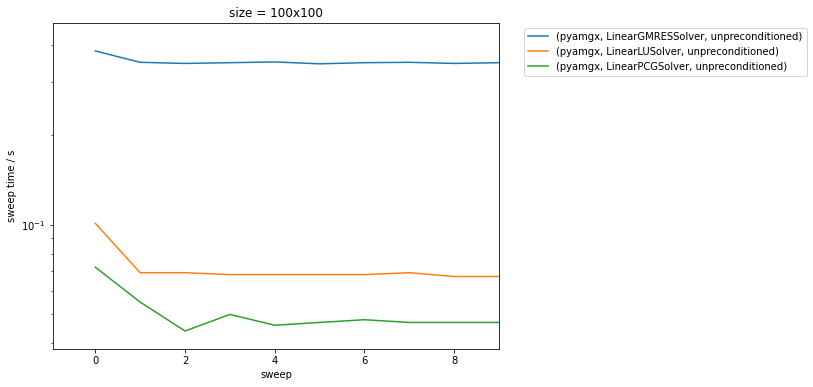

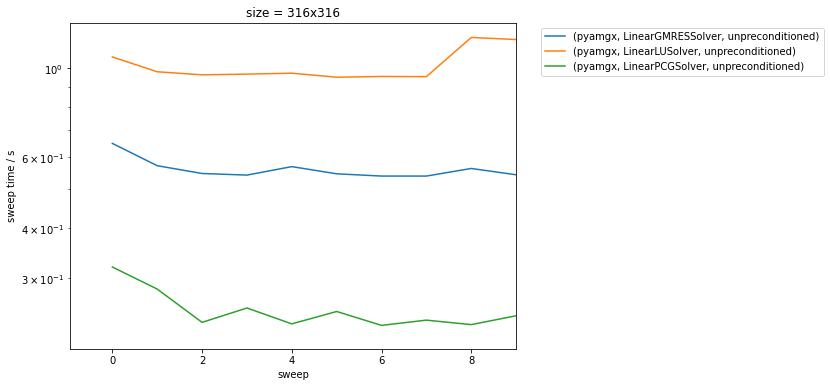

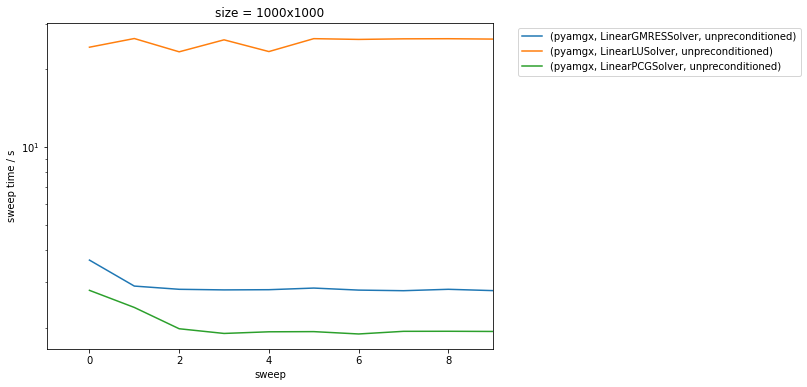

In [381]:
plot_sweep_times(gpu_sweep)

### Linux

In [382]:
events = []
for fname in glob.glob("linux/linux.*.log"):
    events.extend(read_events(fname))

linux = events2df(events)
linux_total = extract_total_times(linux)

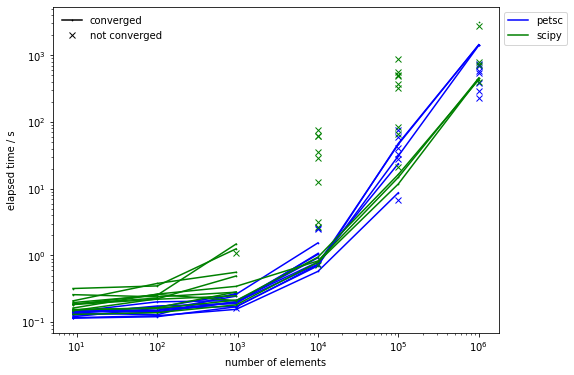

In [383]:
plot_all(linux_total)

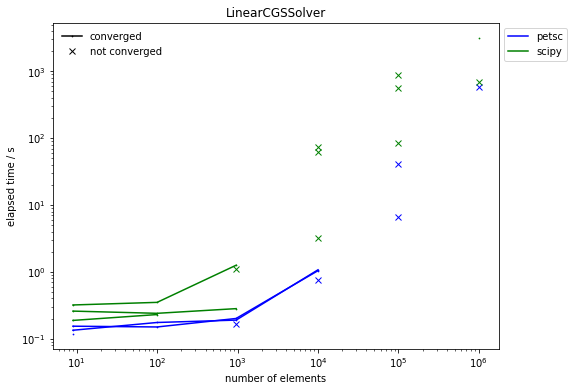

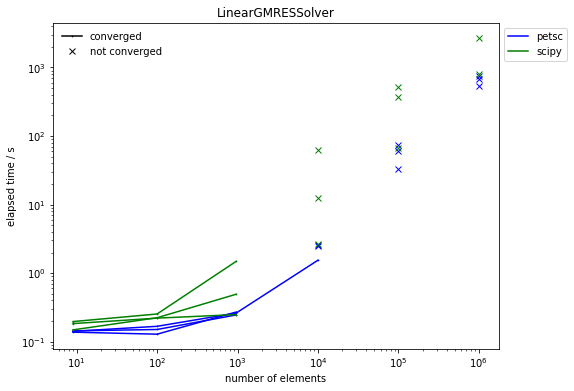

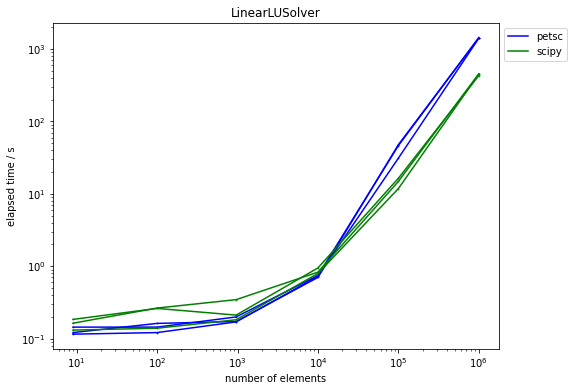

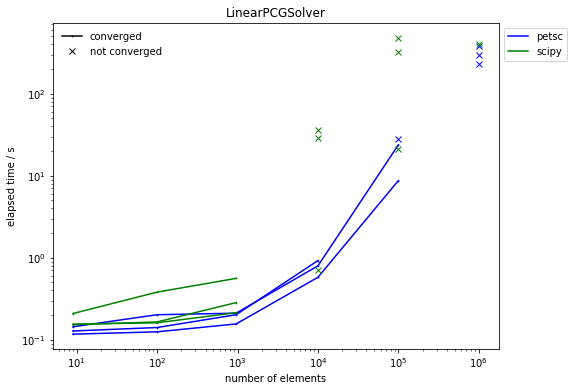

In [384]:
plot_by_solver(linux_total)

#### arithmetic

In [397]:
events = []
for fname in glob.glob("../../../../solvers_and_timings/arithmetic_diffusion/solver.*.log"):
    events.extend(read_events(fname))

arithmetic = events2df(events)
arithmetic_total = extract_total_times(arithmetic)

(10.0, 1000000.0)

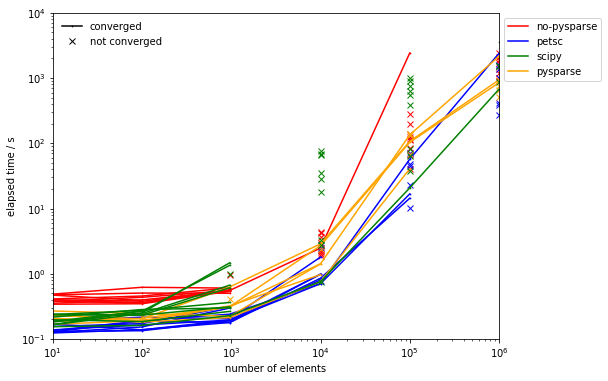

In [398]:
trilinos = arithmetic_total["package.solver"] == "no-pysparse"
petsc = arithmetic_total["package.solver"] == "petsc"
scipy = arithmetic_total["package.solver"] == "scipy"
pysparse = arithmetic_total["package.solver"] == "pysparse"

# plot_all(harmonic_total[pysparse | scipy])
plot_all(arithmetic_total)
plt.ylim(bottom=1e-1, top=1e4)
plt.xlim(left=1e1, right=1e6)

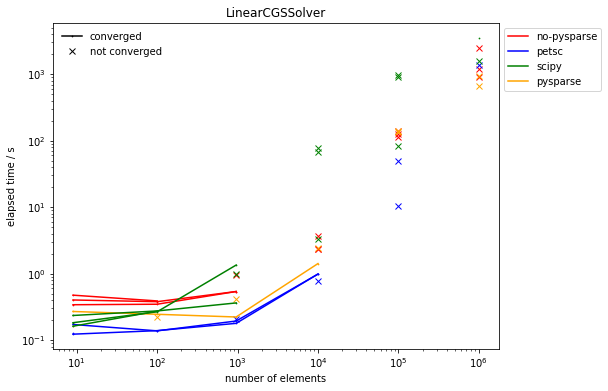

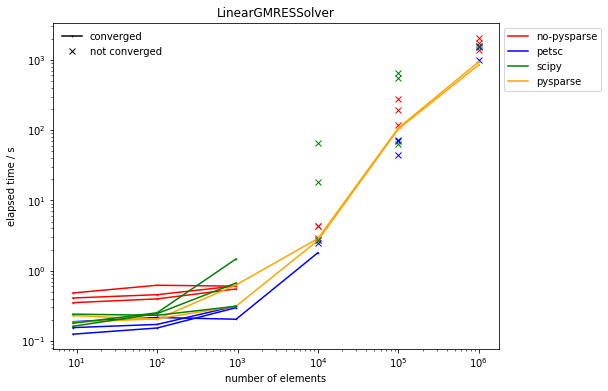

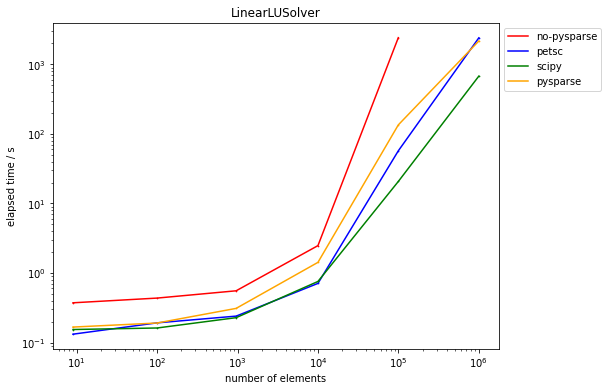

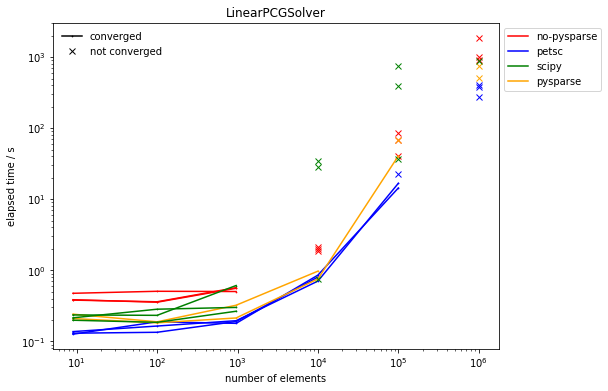

In [393]:
plot_by_solver(arithmetic_total)

In [394]:
events = []
for fname in glob.glob("../../../../solvers_and_timings/harmonic_right/solver.*.log"):
    events.extend(read_events(fname))

harmonic_right = events2df(events)
harmonic_right_total = extract_total_times(harmonic_right)

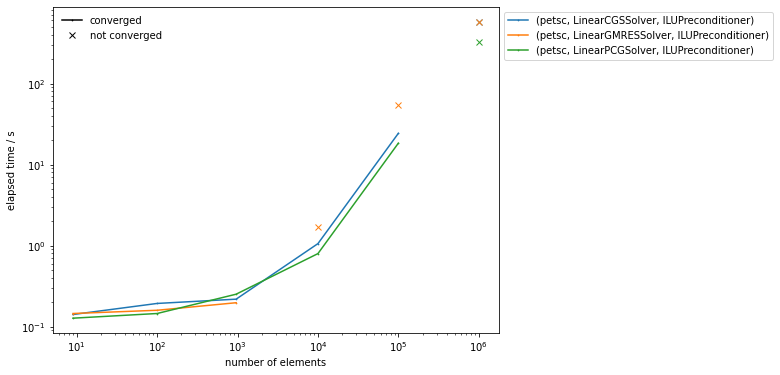

In [396]:
plot_all(harmonic_right_total, color_by_suite=False)

#### harmonic

In [400]:
events = []
for fname in glob.glob("../../../../solvers_and_timings/harmonic/solver.*.log"):
    events.extend(read_events(fname))

harmonic = events2df(events)
harmonic_total = extract_total_times(harmonic)

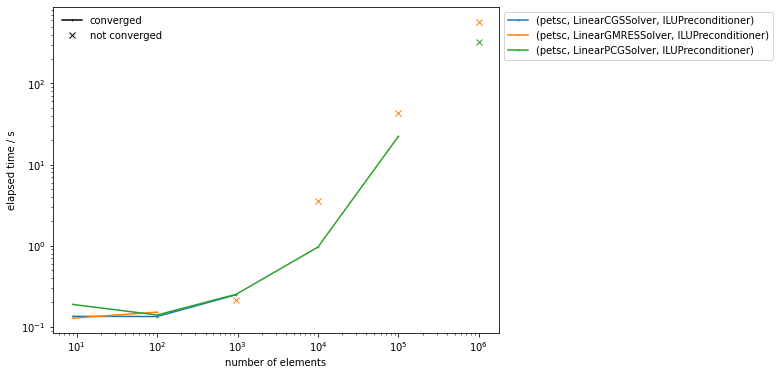

In [401]:
plot_all(harmonic_total, color_by_suite=False)

#### constant

In [385]:
events = []
for fname in glob.glob("../../../../solvers_and_timings/constant_diffusion/solver.*.log"):
    events.extend(read_events(fname))

constant = events2df(events)
constant_total = extract_total_times(constant)

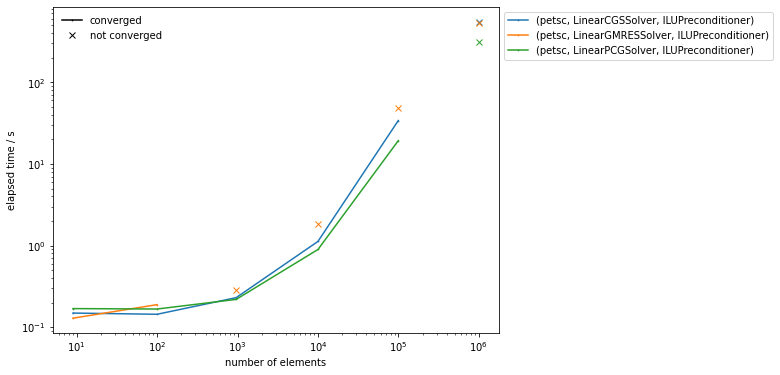

In [387]:
plot_all(constant_total, color_by_suite=False)

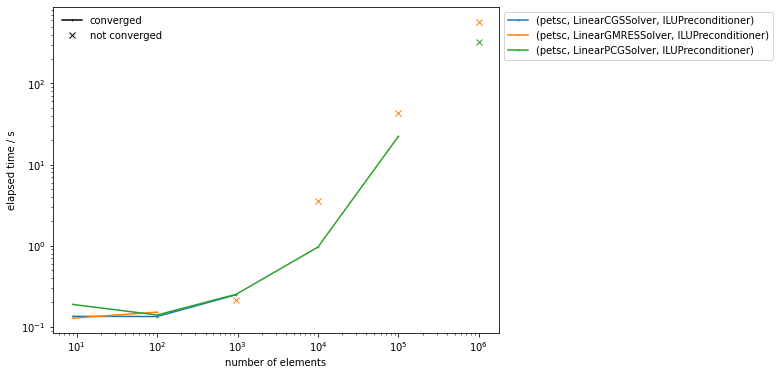

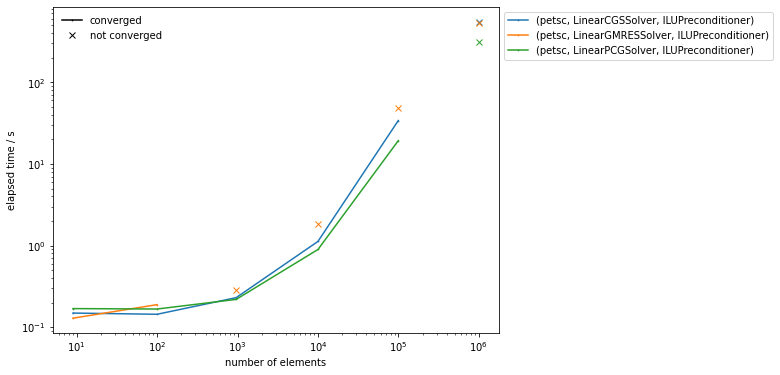

In [390]:
plot_all(harmonic_total, color_by_suite=False)
plot_all(constant_total, color_by_suite=False)

## nucleation

In [442]:
events = []
for fname in glob.glob("../../../../solvers_and_timings/nucleation2[3,5]/solver.*.log"):
    events.extend(read_events(fname))

nucleation = events2df(events)
nucleation_total = extract_total_times(nucleation)

In [408]:
for col in nucleation_total.columns:
    print(col)

state
numberOfElements
sweeps
preconditioner
logfile
time_stamp
solver_class
solve_time
simulation_id
converged
argv
platform.architecture
platform.machine
platform.node
platform.platform
platform.processor
platform.release
platform.system
platform.version
package.python
package.fipy
package.numpy
package.pysparse
package.scipy
package.matplotlib
package.mpi4py
package.petsc4py
package.pyamgx
package.PyTrilinos
package.mayavi
package.gmsh
package.solver
conda.conda_info.GID
conda.conda_info.UID
conda.conda_info.active_prefix
conda.conda_info.active_prefix_name
conda.conda_info.av_data_dir
conda.conda_info.av_metadata_url_base
conda.conda_info.channels
conda.conda_info.conda_build_version
conda.conda_info.conda_env_version
conda.conda_info.conda_location
conda.conda_info.conda_prefix
conda.conda_info.conda_private
conda.conda_info.conda_shlvl
conda.conda_info.conda_version
conda.conda_info.config_files
conda.conda_info.default_prefix
conda.conda_info.env_vars.CDPATH
conda.conda_info.env

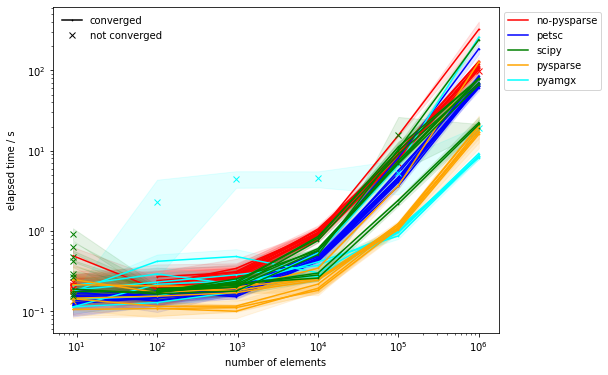

In [445]:
plot_all(nucleation_total)

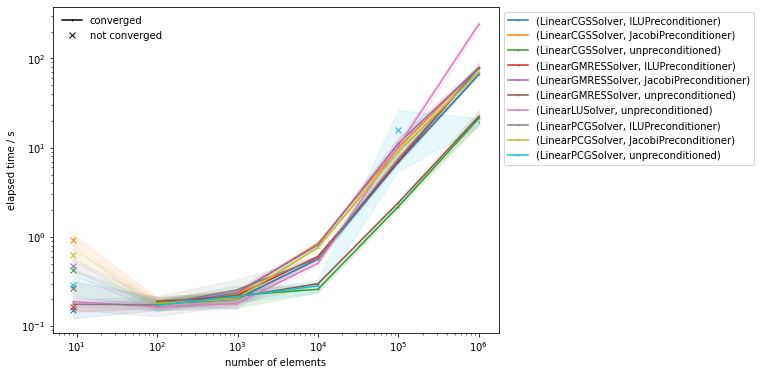

In [455]:
trilinos = nucleation_total["package.solver"] == "no-pysparse"
petsc = nucleation_total["package.solver"] == "petsc"
scipy = nucleation_total["package.solver"] == "scipy"
pysparse = nucleation_total["package.solver"] == "pysparse"
pyamgx = nucleation_total["package.solver"] == "pyamgx"

plot_all(nucleation_total[scipy], color_by_suite=False,
         by=["solver_class", "preconditioner"])
# plot_all(nucleation_total)
# plt.ylim(bottom=1e-1, top=1e3)
# plt.xlim(left=1e1, right=1e6)

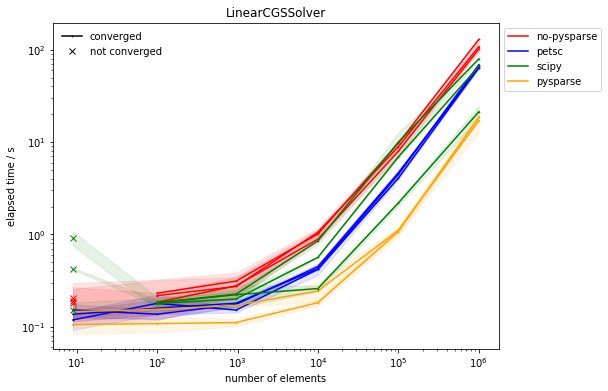

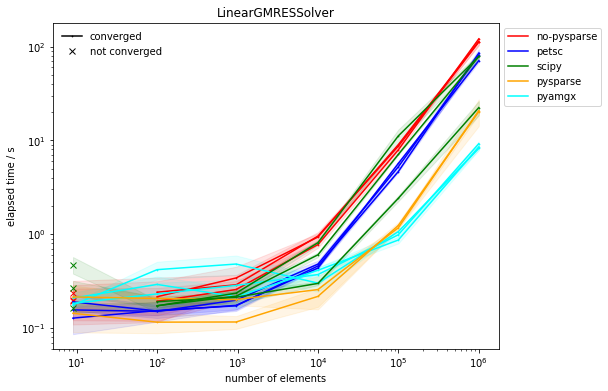

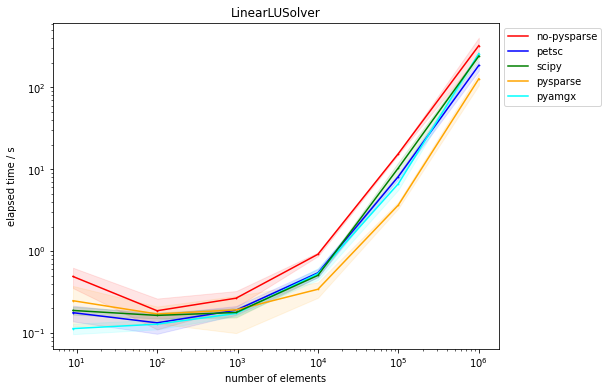

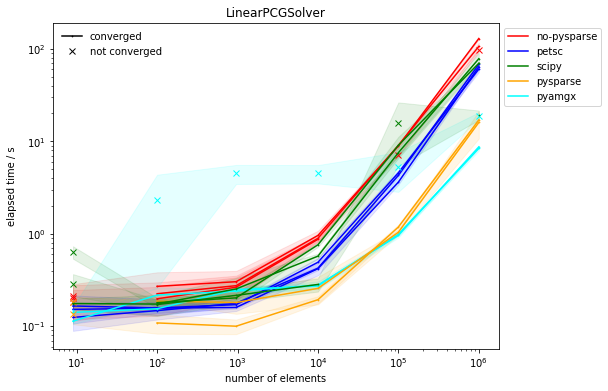

In [447]:
plot_by_solver(nucleation_total)

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_35854/1616617774.py:35: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


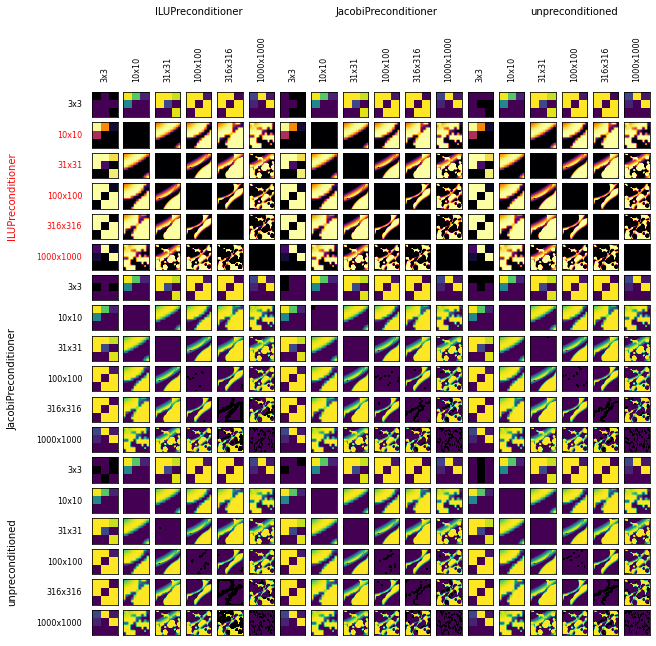

In [646]:
plot_error_matrix(nucleation_total[(nucleation_total["package.solver"] == "petsc")
                                   & (nucleation_total["solver_class"] == "LinearGMRESSolver")],
                  nucleation_total[(nucleation_total["package.solver"] == "pyamgx")
                                   & (nucleation_total["solver_class"] == "LinearPCGSolver")],
                  by=["preconditioner", "numberOfElements"],
                  datafile="t=301.0.npz", key="phi")

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_35854/1616617774.py:35: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


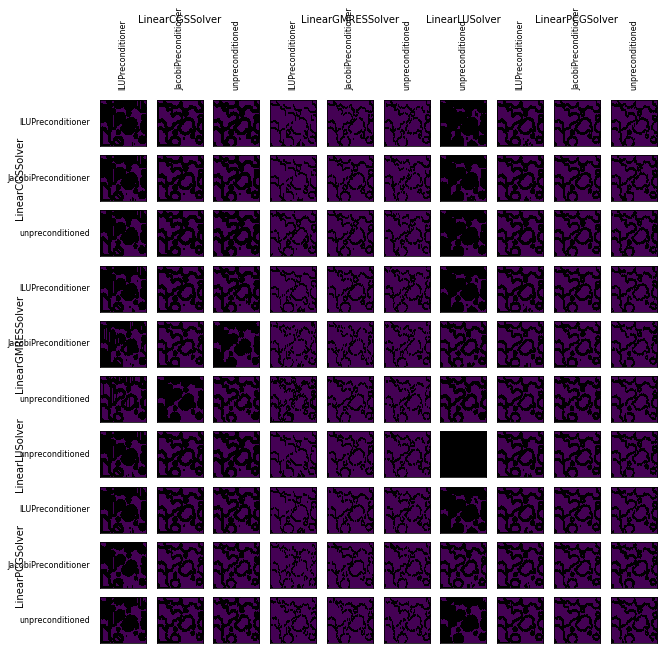

In [650]:
plot_error_matrix(nucleation_total[(nucleation_total["package.solver"] == "petsc")
                                   & (nucleation_total["numberOfElements"] == 10**6)],
                  nucleation_total[(nucleation_total["package.solver"] == "scipy")
                                   & (nucleation_total["numberOfElements"] == 10**6)],
                  by=["solver_class", "preconditioner"],
                  datafile="t=301.0.npz", key="phi")

## Compare solutions

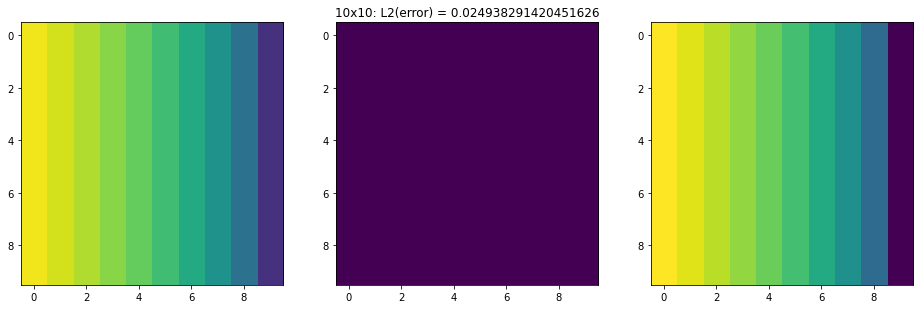

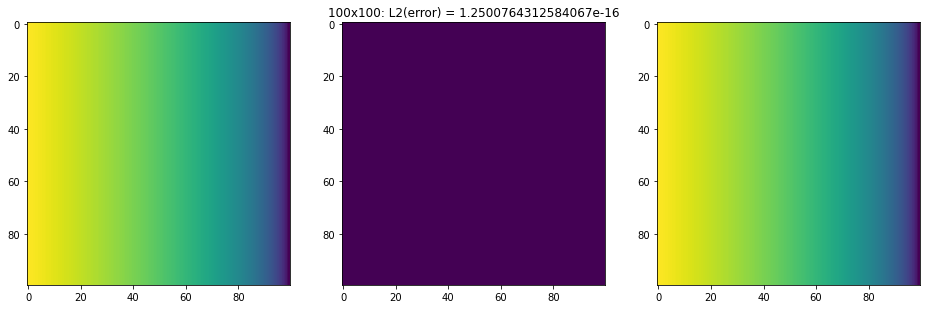

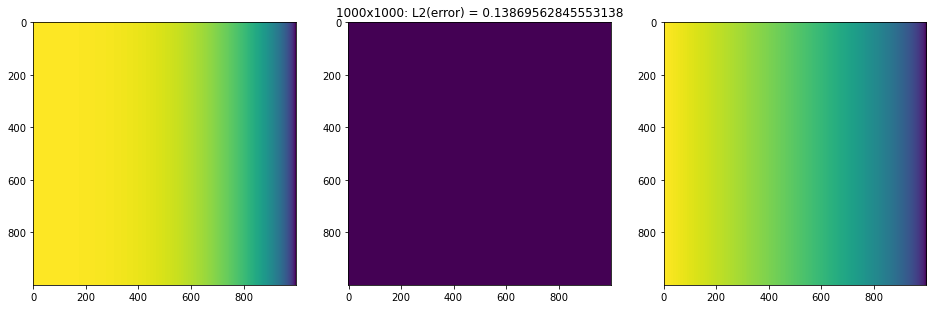

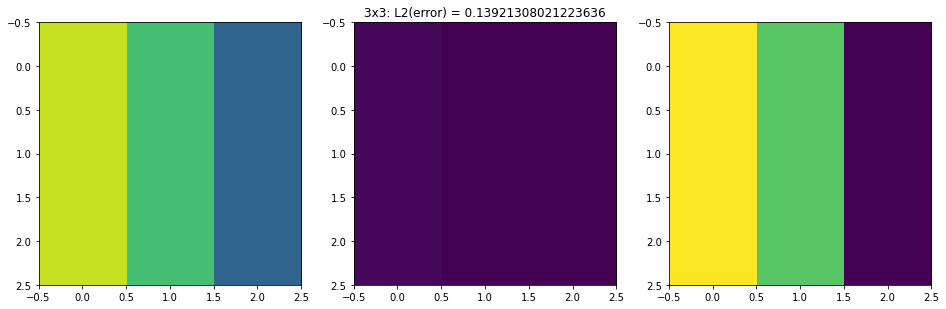

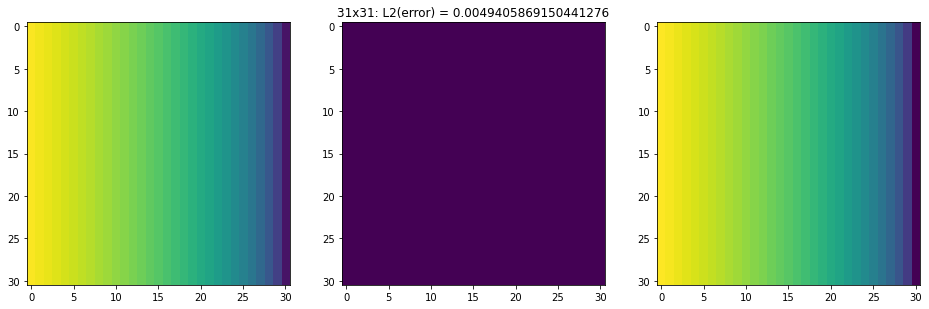

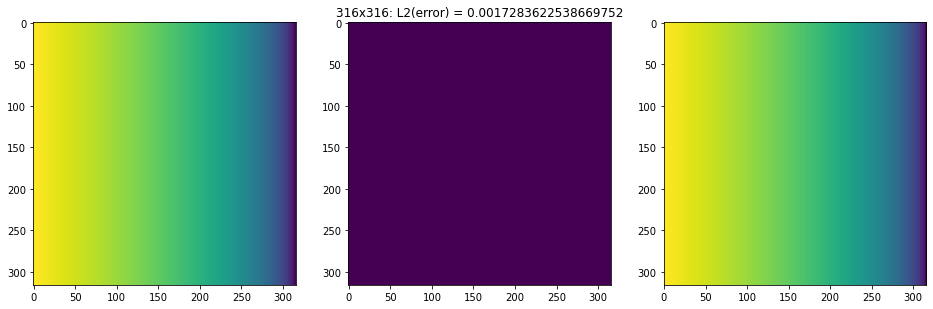

In [57]:
reference = "gpu/pyamgx/LinearGMRESSolver/10000/solution.tsv"
datasets = glob.glob("gpu/pyamgx/LinearGMRESSolver/*/solution.tsv")
datasets.sort()
for dataset in datasets:
    compare(dataset, reference)

In [125]:
for path in glob.glob("linux/petsc/LinearPCGSolver/*/*/solution.tsv"):
    tsv2npz(path)

In [354]:
for path in glob.glob("linux/petsc/LinearGMRESSolver/*/*/solution.tsv"):
    tsv2npz(path)

In [355]:
for path in glob.glob("linux/petsc/LinearCGSSolver/*/*/solution.tsv"):
    tsv2npz(path)

In [356]:
for path in glob.glob("linux/petsc/LinearLUSolver/*/*/solution.tsv"):
    tsv2npz(path)

In [357]:
for path in glob.glob("linux/scipy/*/*/*/solution.tsv"):
    tsv2npz(path)

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_35854/2948526623.py:31: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


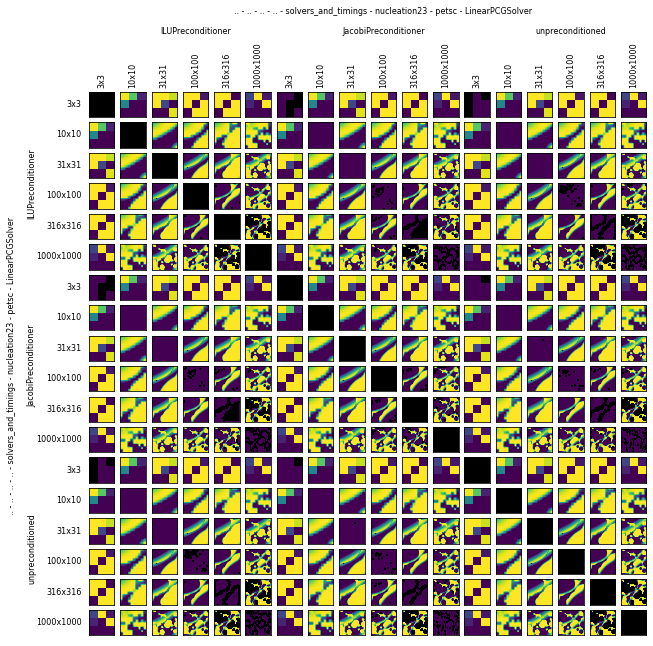

In [50]:
plot_error_matrix("../../../../solvers_and_timings/nucleation23/petsc/LinearPCGSolver/*/*/t=301.0.npz",
                  "../../../../solvers_and_timings/nucleation23/petsc/LinearPCGSolver/*/*/t=301.0.npz",
                  nucleation, key="phi")

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_35854/2948526623.py:31: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


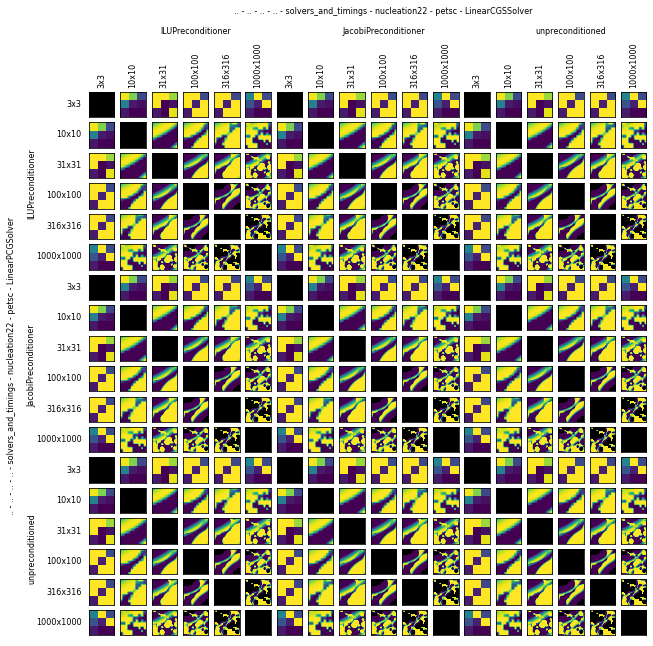

In [46]:
plot_error_matrix("../../../../solvers_and_timings/nucleation22/petsc/LinearCGSSolver/*/*/t=300.0.npz",
                  "../../../../solvers_and_timings/nucleation22/petsc/LinearPCGSolver/*/*/t=300.0.npz",
                  nucleation, key="phi")

In [42]:
plot_error_matrix("../../../../solvers_and_timings/harmonic/petsc/LinearPCGSolver/*/*/solution.npz",
                  "../../../../solvers_and_timings/harmonic_right/scipy/LinearPCGSolver/*/*/solution.npz",
                  harmonic)

ValueError: too many values to unpack (expected 6)

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_69873/2078872991.py:31: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


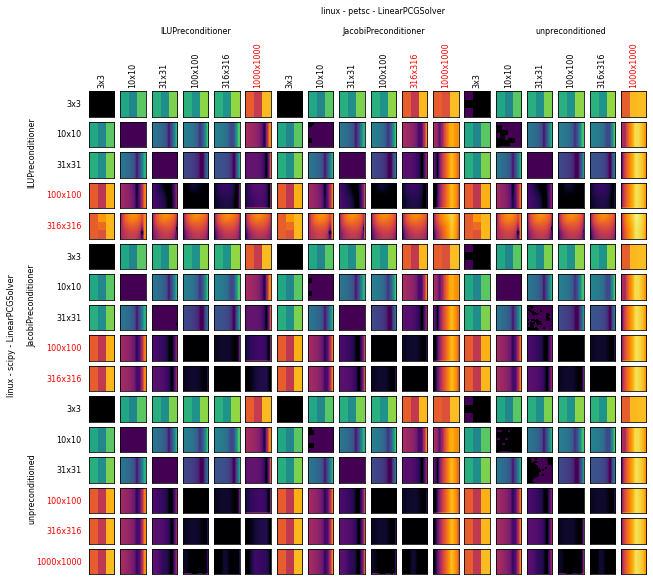

In [352]:
plot_error_matrix("linux/petsc/LinearPCGSolver/*/*/solution.npz",
                  "linux/scipy/LinearPCGSolver/*/*/solution.npz",
                  linux)

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_69873/2078872991.py:31: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


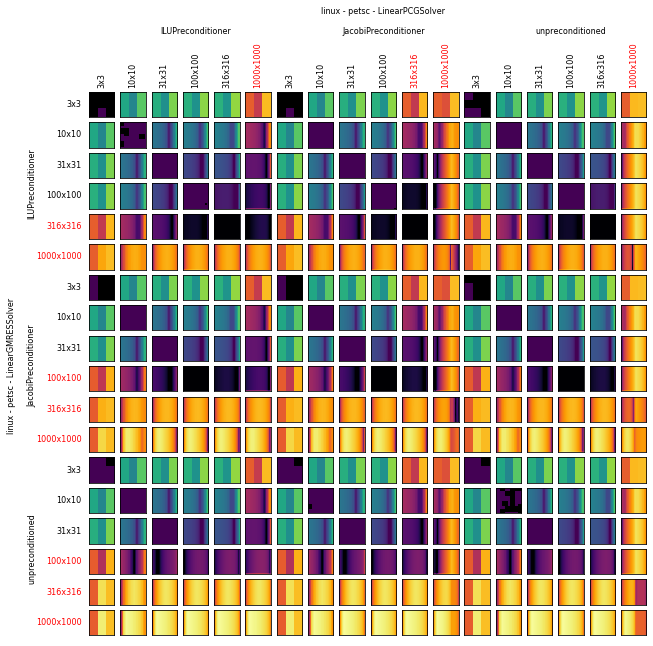

In [358]:
plot_error_matrix("linux/petsc/LinearPCGSolver/*/*/solution.npz",
                  "linux/petsc/LinearGMRESSolver/*/*/solution.npz",
                  linux)

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_69873/2078872991.py:31: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


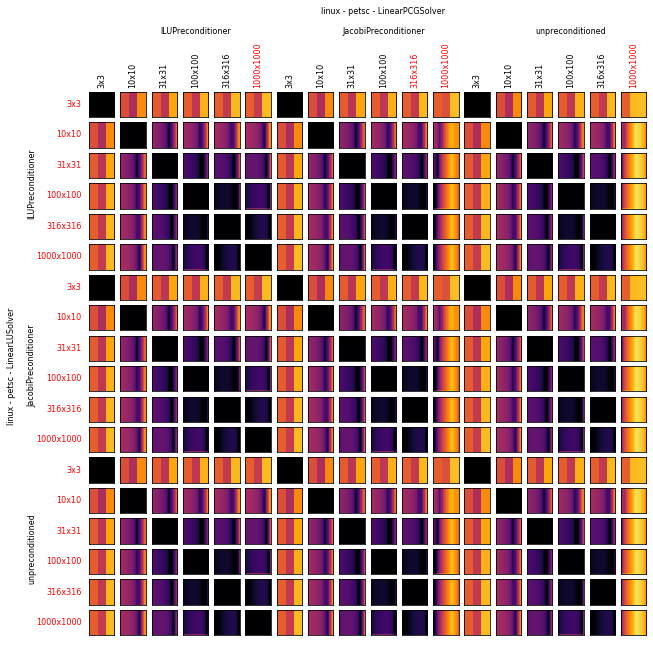

In [359]:
plot_error_matrix("linux/petsc/LinearPCGSolver/*/*/solution.npz",
                  "linux/petsc/LinearLUSolver/*/*/solution.npz",
                  linux)

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_69873/2078872991.py:31: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


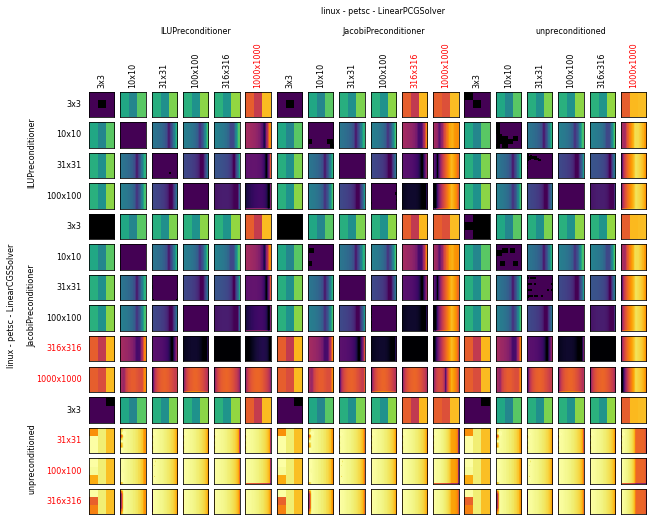

In [360]:
plot_error_matrix("linux/petsc/LinearPCGSolver/*/*/solution.npz",
                  "linux/petsc/LinearCGSSolver/*/*/solution.npz",
                  linux)

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_69873/2078872991.py:31: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


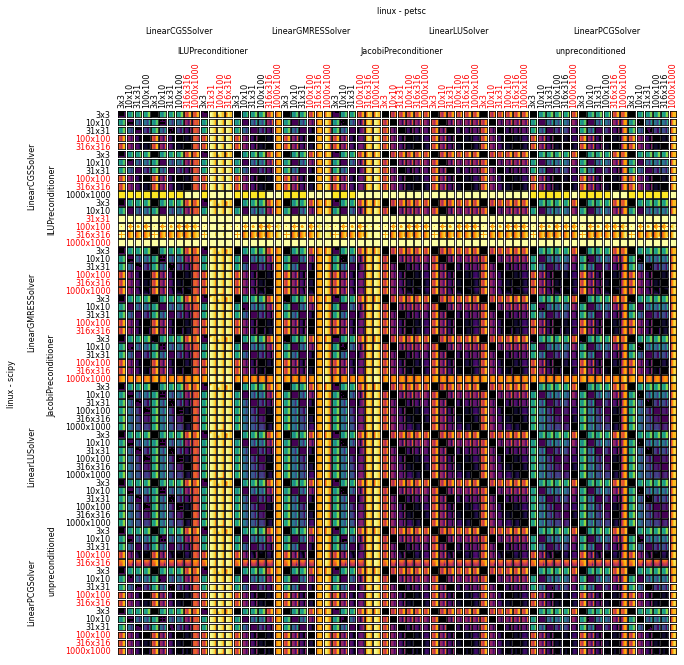

In [361]:
plot_error_matrix("linux/petsc/*/*/*/solution.npz",
                  "linux/scipy/*/*/*/solution.npz",
                  linux)

/var/folders/yc/1ssnjn654bs1n_0rts218cn0000j9v/T/ipykernel_69873/2078872991.py:31: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(np.absolute(diff)), cmap=cmap, vmin=-3, vmax=0)


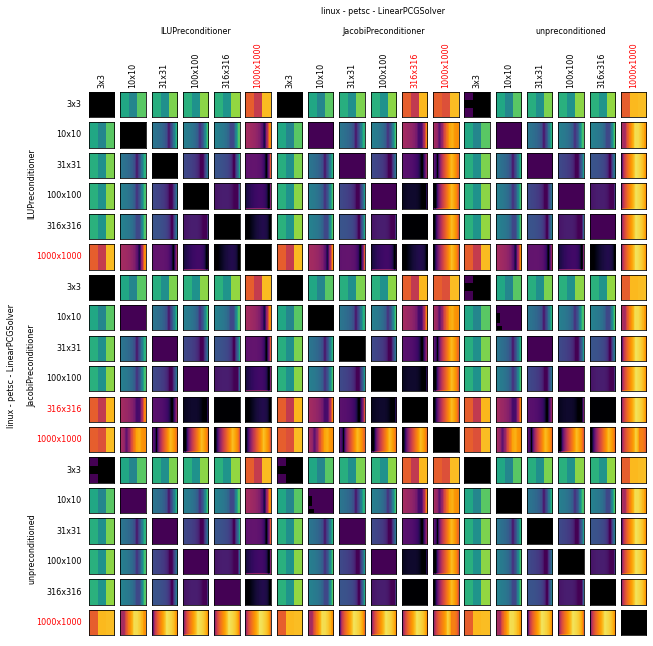

In [353]:
plot_error_matrix("linux/petsc/LinearPCGSolver/*/*/solution.npz",
                  "linux/petsc/LinearPCGSolver/*/*/solution.npz",
                  linux)